In [2]:
import pandas as pd

train_df = pd.read_csv('train_v2.csv')
submission_df = pd.read_csv('sample_submission_v2.csv')

print(train_df.head())
print(submission_df.head())


  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
  image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water


In [3]:
# Count the occurrences of each label
label_counts = train_df['tags'].str.split(' ').explode().value_counts()

# Print the label counts
print(label_counts)


tags
primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
Name: count, dtype: int64


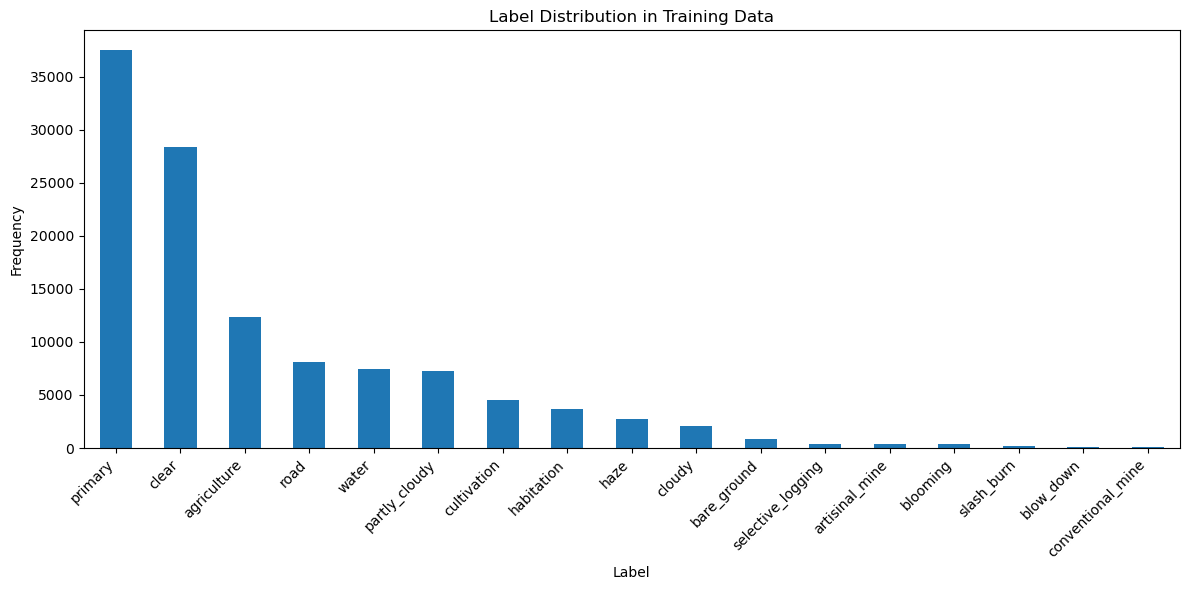

In [4]:
import matplotlib.pyplot as plt

# Plot the label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [5]:
from sklearn.model_selection import train_test_split

# Split the data into 80% train and 20% validation/test
train_df, val_test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Split the validation/test data into 50% validation and 50% test
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


(32383, 2)
(4048, 2)
(4048, 2)


In [6]:
# Extract image names and construct paths
train_image_names = train_df['image_name'].tolist()
train_image_paths = ['train-jpg/' + name + '.jpg' for name in train_image_names]

val_image_names = val_df['image_name'].tolist()
val_image_paths = ['train-jpg/' + name + '.jpg' for name in val_image_names]

test_image_names = test_df['image_name'].tolist()
test_image_paths = ['train-jpg/' + name + '.jpg' for name in test_image_names]

# Define all possible labels
possible_labels = ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

# Multi-hot encode labels
train_labels = []
for index, row in train_df.iterrows():
    labels = row['tags'].split()
    label_vector = [1 if label in labels else 0 for label in possible_labels]
    train_labels.append(label_vector)

val_labels = []
for index, row in val_df.iterrows():
    labels = row['tags'].split()
    label_vector = [1 if label in labels else 0 for label in possible_labels]
    val_labels.append(label_vector)

test_labels = []
for index, row in test_df.iterrows():
    labels = row['tags'].split()
    label_vector = [1 if label in labels else 0 for label in possible_labels]
    test_labels.append(label_vector)



In [7]:
# Check for missing values in 'tags' column
print(train_df['tags'].isnull().sum())
print(val_df['tags'].isnull().sum())
print(test_df['tags'].isnull().sum())

# Check for unique labels
all_labels = []
for df in [train_df, val_df, test_df]:
    all_labels.extend(df['tags'].str.split(' ').explode().unique())
unique_labels = set(all_labels)
print(unique_labels)



0
0
0
{'partly_cloudy', 'cultivation', 'agriculture', 'road', 'water', 'blooming', 'artisinal_mine', 'clear', 'conventional_mine', 'bare_ground', 'selective_logging', 'primary', 'slash_burn', 'haze', 'habitation', 'cloudy', 'blow_down'}


In [8]:
def dark_channel_prior(images, patch_size=15, omega=0.95):
    """
    Implements a simple version of the dark channel prior method for haze removal.

    Args:
        images: A batch of images in the format [batch_size, height, width, channels].
        patch_size: The size of the patch to use for finding the dark channel.
        omega: The amount of haze to remove.

    Returns:
        A batch of haze-free images.
    """

    # Find the dark channel
    dark_channel = tf.nn.max_pool(
        -images,
        ksize=[1, patch_size, patch_size, 1],
        strides=[1, 1, 1, 1],
        padding='SAME'
    )

    # Estimate the atmospheric light
    atmospheric_light = tf.reduce_max(tf.reshape(images, [-1, 3]), axis=0)

    # Recover the haze-free image
    transmission = 1 - omega * dark_channel / atmospheric_light
    haze_free_images = (images - atmospheric_light) / transmission + atmospheric_light

    return haze_free_images



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)



2024-06-04 22:47:13.235470: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 22:47:13.239075: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 22:47:14.171827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
import tensorflow as tf

# Assuming image size is (128, 128, 3) based on common practices
IMG_SIZE = (128, 128)

# Load pre-trained ResNet50 model without the top classification layer
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers
for layer in base_model.layers[:-5]:  # Unfreeze the last 5 layers for fine-tuning
    layer.trainable = False

# Add a classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(17, activation='sigmoid')(x)  # 17 output classes

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

print(model.summary())


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 57s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,852,177 (90.99 MB)

 Trainable params: 1,319,185 (5.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

None


In [20]:
import keras.backend as K

def f2_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=1)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, 'float'), axis=1)
    actual_positives = tf.reduce_sum(tf.cast(y_true, 'float'), axis=1)
    
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (actual_positives + tf.keras.backend.epsilon())
    
    f2 = (5 * precision * recall) / (4 * precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f2)

def f2_loss(y_true, y_pred):
    return 1 - f2_score(y_true, y_pred)


In [21]:
model.compile(optimizer='adam', loss=f2_loss, metrics=[f2_score])


In [22]:
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image

class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, dim=(128, 128), n_channels=3, n_classes=17, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]
        
        X, y = self.__data_generation(image_paths_temp, labels_temp)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, image_paths_temp, labels_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))
        
        for i, (img_path, label) in enumerate(zip(image_paths_temp, labels_temp)):
            img = Image.open(img_path).convert('RGB')  # Convert image to RGB format
            img = img.resize(self.dim)
            img = np.array(img)
            
            if img.shape[-1] == 1:
                img = np.stack((img,) * 3, axis=-1)
                
            X[i,] = img
            y[i,] = label
        
        return X, y

# Create data generators
train_generator = DataGenerator(train_image_paths, train_labels, batch_size=32)
val_generator = DataGenerator(val_image_paths, val_labels, batch_size=32, shuffle=False)



In [23]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_f2_score', mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_f2_score', mode='max', patience=5, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


ValueError: No gradients provided for any variable.